In [1]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
from datetime import date
from datetime import timedelta
import math
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Libraries for Deep Learning Models
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Error Metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.stats import spearmanr, pearsonr

#Technical Indicators
from ta.trend import MACD, EMAIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from sklearn.metrics import accuracy_score, classification_report

#Wavelet Decomposition
import pywt

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
Data = pd.read_excel("Features_Final.xlsx", index_col = 0)

<AxesSubplot:>

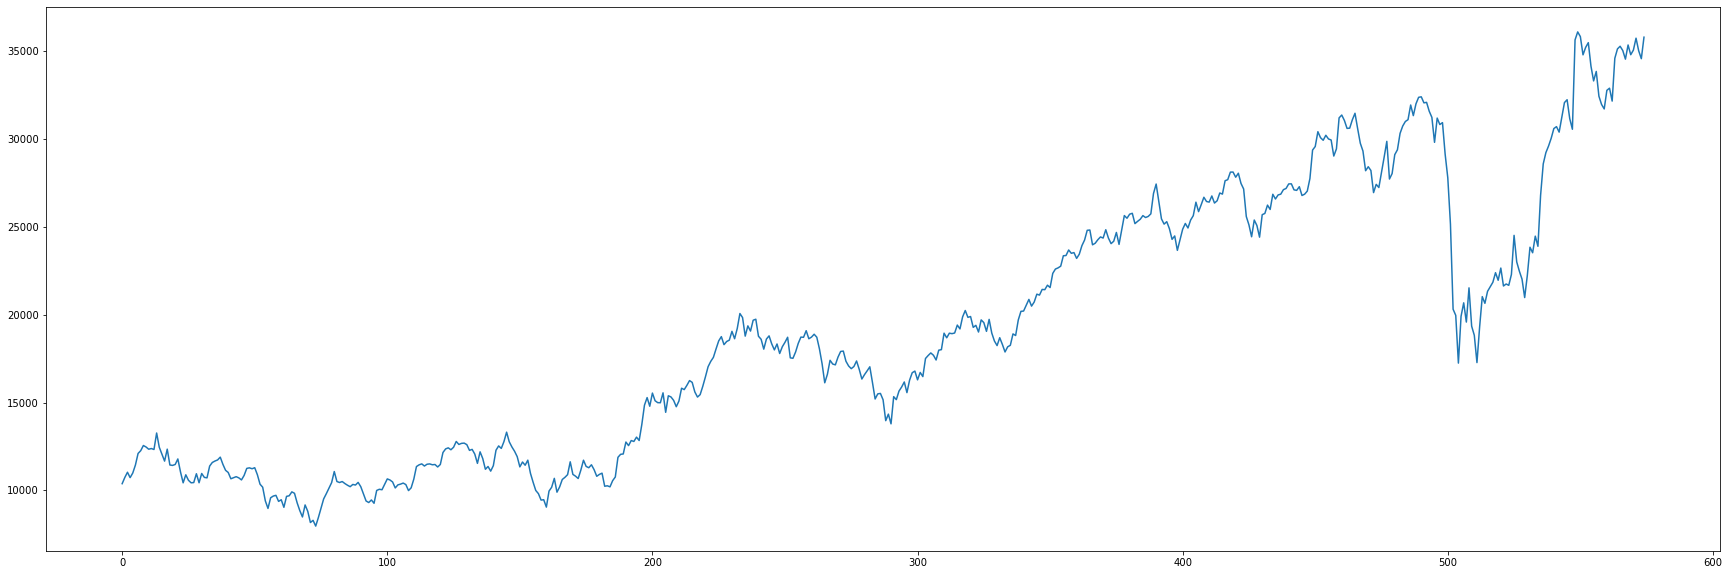

In [3]:
Data["Bank_Nifty"].plot(figsize = (30,10))

In [4]:
Data

,Date,AD_Ratio,5%_Up,8%_Up,13%_Up,Down,Frac_EMA8,Frac_EMA13,Frac_EMA21,Frac_EMA34,...,Nifty_EMA55,Nifty_EMA89,Nifty_EMA144,Nifty_EMA233,ATR,L_BB_PCT_CHANGE,H_BB_PCT_CHANGE,B_BB_PCT_CHANGE,Lagged_Labels,Labels
0,2010-08-02,2.428571,0.125000,0.083333,0.041667,7,0.833333,0.875000,0.875000,0.875000,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,2,2
1,2010-08-09,7.000000,0.291667,0.166667,0.041667,3,0.875000,0.916667,0.916667,0.916667,...,1,1,1,1,0.000000,4.941163,-1.647054,1.647054,2,2
2,2010-08-16,3.800000,0.375000,0.250000,0.041667,5,0.916667,0.916667,0.916667,0.916667,...,1,1,1,1,0.000000,7.676368,-1.957551,2.859409,2,0
3,2010-08-23,0.200000,0.041667,0.041667,0.041667,20,0.875000,0.916667,0.916667,0.916667,...,1,1,1,1,95.608581,4.355685,-4.227043,0.064321,0,2
4,2010-08-30,5.000000,0.250000,0.041667,0.083333,4,0.916667,0.916667,0.916667,0.916667,...,1,1,1,1,387.308307,6.202518,-2.262639,1.969940,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,2021-07-05,0.411765,0.041667,0.041667,0.041667,17,0.541667,0.666667,0.750000,0.791667,...,1,1,1,1,215.166209,1.835638,-1.256428,0.289605,1,2
571,2021-07-12,1.000000,0.041667,0.041667,0.041667,12,0.541667,0.625000,0.750000,0.833333,...,1,1,1,1,88.736903,4.129087,-0.545827,1.791630,2,0
572,2021-07-19,0.263158,0.041667,0.041667,0.041667,19,0.250000,0.291667,0.625000,0.750000,...,1,1,1,1,97.419191,1.362660,-2.345351,-0.491346,0,1
573,2021-07-26,1.000000,0.041667,0.041667,0.041667,12,0.333333,0.500000,0.625000,0.708333,...,1,1,1,1,92.524153,0.918239,-3.613844,-1.347802,1,2


In [5]:
X = pd.DataFrame(Data["Bank_Nifty"])
X["India_Vix"] = Data["India_Vix"]
X["AD_Ratio"]  = Data["AD_Ratio"]
y = Data["Bank_Nifty"].shift(-1)
y = y.rename("Labels")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [6]:
train_data = pd.concat((X_train, y_train), axis=1)

In [7]:
train_data

,Bank_Nifty,India_Vix,AD_Ratio,Labels
0,10383.65,18.94,2.428571,10737.35
1,10737.35,17.37,7.000000,11033.75
2,11033.75,16.74,3.800000,10727.45
3,10727.45,16.70,0.200000,10991.20
4,10991.20,19.63,5.000000,11446.70
...,...,...,...,...
455,30013.50,22.74,0.500000,29954.15
456,29954.15,21.72,0.333333,29040.50
457,29040.50,24.03,0.200000,29450.15
458,29450.15,26.34,0.600000,31212.55


In [8]:
while(pywt.swt_max_level(train_data.shape[0]) < 2):
    train_data = train_data.drop(train_data.index[0], axis = 0)

In [9]:
haar = pywt.Wavelet('haar')
(cA2, cD2), (cA1, cD1) = pywt.swt(train_data["Bank_Nifty"], haar, level=2)

Text(0.5, 1.0, 'cD2')

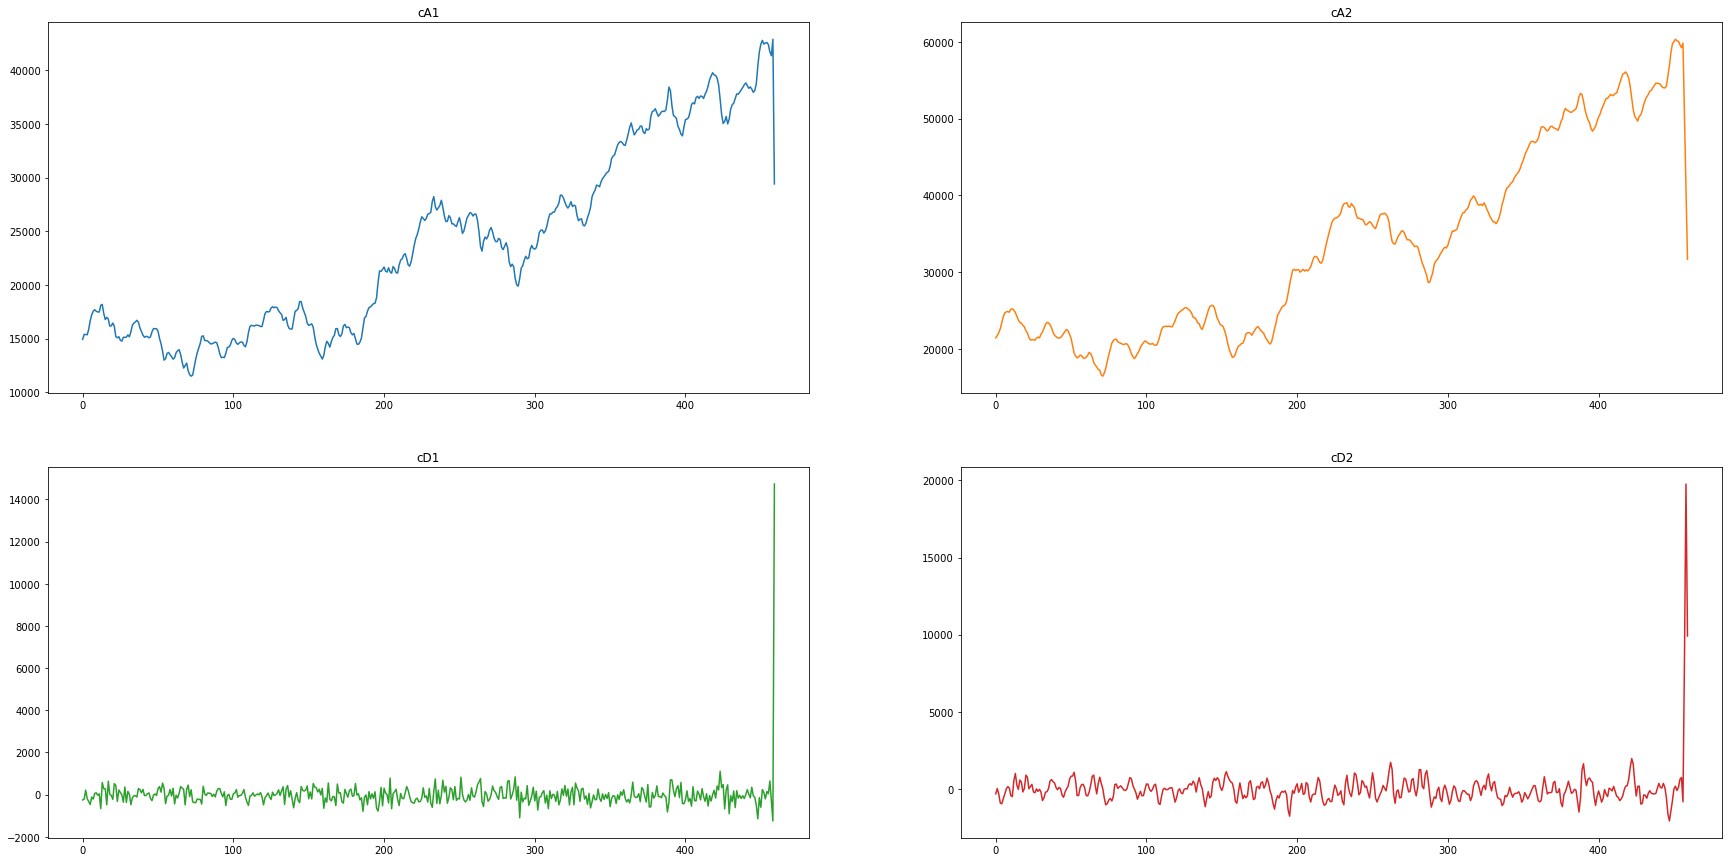

In [10]:
fig, axs = plt.subplots(2, 2, figsize= (30,15))
axs[0, 0].plot(cA1)
axs[0, 0].set_title('cA1')
axs[0, 1].plot(cA2, 'tab:orange')
axs[0, 1].set_title('cA2')
axs[1, 0].plot(cD1 , 'tab:green')
axs[1, 0].set_title('cD1')
axs[1, 1].plot(cD2, 'tab:red')
axs[1, 1].set_title('cD2')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')
#
## Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

In [11]:
train_data["cA1"] = cA1
train_data["cA2"] = cA2
train_data["cD1"] = cD1
train_data["cD2"] = cA2
train_data

,Bank_Nifty,India_Vix,AD_Ratio,Labels,cA1,cA2,cD1,cD2
0,10383.65,18.94,2.428571,10737.35,14934.802325,21441.100,-250.103669,21441.100
1,10737.35,17.37,7.000000,11033.75,15394.492444,21744.875,-209.586450,21744.875
2,11033.75,16.74,3.800000,10727.45,15387.492087,22099.550,216.586807,22099.550
3,10727.45,16.70,0.200000,10991.20,15357.404693,22634.725,-186.499414,22634.725
4,10991.20,19.63,5.000000,11446.70,15865.991246,23402.775,-322.087139,23402.775
...,...,...,...,...,...,...,...,...
455,30013.50,22.74,0.500000,29954.15,42403.531967,59229.150,41.966787,59229.150
456,29954.15,21.72,0.333333,29040.50,41715.517069,59828.675,646.048111,59828.675
457,29040.50,24.03,0.200000,29450.15,41359.135251,50043.425,-289.666293,50043.425
458,29450.15,26.34,0.600000,31212.55,42895.006535,40891.850,-1246.204991,40891.850


In [12]:
train_data.drop("Labels", axis =1)

,Bank_Nifty,India_Vix,AD_Ratio,cA1,cA2,cD1,cD2
0,10383.65,18.94,2.428571,14934.802325,21441.100,-250.103669,21441.100
1,10737.35,17.37,7.000000,15394.492444,21744.875,-209.586450,21744.875
2,11033.75,16.74,3.800000,15387.492087,22099.550,216.586807,22099.550
3,10727.45,16.70,0.200000,15357.404693,22634.725,-186.499414,22634.725
4,10991.20,19.63,5.000000,15865.991246,23402.775,-322.087139,23402.775
...,...,...,...,...,...,...,...
455,30013.50,22.74,0.500000,42403.531967,59229.150,41.966787,59229.150
456,29954.15,21.72,0.333333,41715.517069,59828.675,646.048111,59828.675
457,29040.50,24.03,0.200000,41359.135251,50043.425,-289.666293,50043.425
458,29450.15,26.34,0.600000,42895.006535,40891.850,-1246.204991,40891.850


In [13]:
Scaler = MinMaxScaler(feature_range = (0,1))
Price_Scaler = MinMaxScaler(feature_range = (0,1))
train_labels = Price_Scaler.fit_transform(np.array(train_data["Labels"]).reshape(-1,1))
train_data = Scaler.fit_transform(train_data.drop("Labels", axis =1))

prediction_days  = 10

X_train = []
Y_train = []

for i in range(prediction_days+1, len(train_data) -1):
    X_train.append(train_data[i - prediction_days: i, :])
    Y_train.append(train_labels[i])

X_train , Y_train = np.array(X_train), np.array(Y_train)

In [14]:
%%time
#Build the Model
model = Sequential()

model.add(LSTM(units = 60, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "relu"))
model.compile(optimizer = "Adam", loss = "mean_squared_error")
model.fit(X_train, Y_train, epochs = 100, batch_size = 16 , verbose = 0, shuffle = False)

Wall time: 10.4 s


In [15]:
train_predicted_prices = model.predict(X_train)
train_predicted_prices = Price_Scaler.inverse_transform(train_predicted_prices)
train_actual_prices = Price_Scaler.inverse_transform(Y_train.reshape(-1,1))

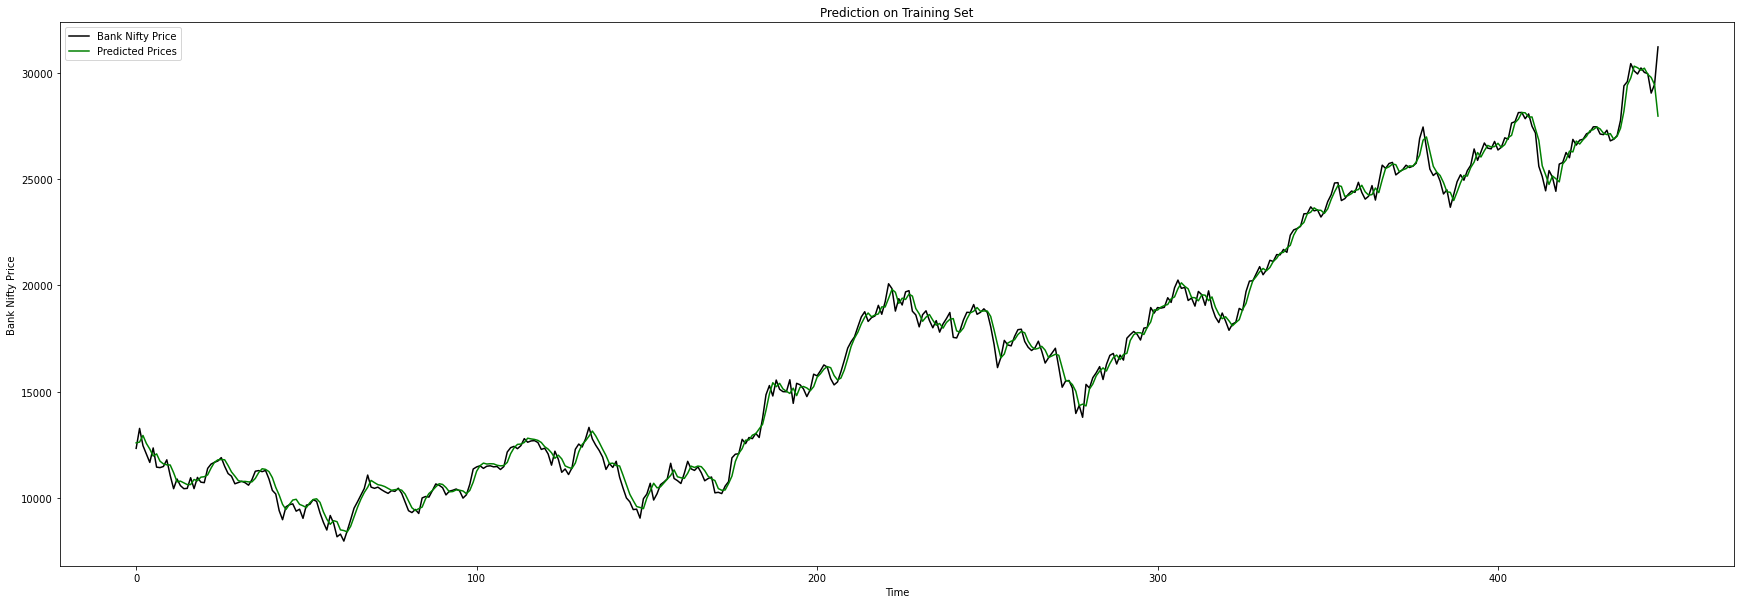

In [16]:
plt.figure(figsize = (30,10))
plt.plot(train_actual_prices, color = "black", label = "Bank Nifty Price")
plt.plot(train_predicted_prices, color = "green", label = "Predicted Prices")
plt.title("Prediction on Training Set")
plt.xlabel("Time")
plt.ylabel("Bank Nifty Price")
plt.legend()
plt.show()

In [17]:
corr, _ = pearsonr(train_actual_prices.flatten(), train_predicted_prices.flatten())
print("Pearson Corelation Coefficient =", corr)

Pearson Corelation Coefficient = 0.9979764110537279


In [18]:
corr, _ = spearmanr(train_actual_prices, train_predicted_prices)
print("Spearman Corelation Coefficient =", corr)

Spearman Corelation Coefficient = 0.9956464189089633


In [19]:
np.sqrt(mean_squared_error(train_actual_prices, train_predicted_prices))

395.1390963060966

In [20]:
mean_absolute_percentage_error(train_actual_prices, train_predicted_prices)

0.019324113010418247

In [21]:
test_data = pd.concat((X_test, y_test), axis=1)

In [22]:
test_data

,Bank_Nifty,India_Vix,AD_Ratio,Labels
460,31375.400000,16.47,0.714286,31066.550000
461,31066.550000,16.07,0.333333,30614.350000
462,30614.350000,14.86,0.600000,30628.350000
463,30628.350000,13.90,0.714286,31105.200000
464,31105.200000,14.61,3.000000,31475.800000
...,...,...,...,...
570,35071.950000,12.09,0.411765,35751.800000
571,35751.800000,12.94,1.000000,35034.400000
572,35034.400000,11.71,0.263158,34584.351562
573,34584.351562,11.76,1.000000,35809.250000


In [23]:
while(pywt.swt_max_level(test_data.shape[0]) < 2):
    test_data = test_data.drop(test_data.index[0], axis = 0)
test_actual_prices = test_data["Bank_Nifty"].values    
#test_dates =  test_data.index[prediction_days+1:]

In [24]:
test_data.shape

(112, 4)

In [25]:
if(pywt.swt_max_level(test_data.shape[0]) >= 2):
    (test_cA2, test_cD2), (test_cA1, test_cD1) = pywt.swt(test_data["Bank_Nifty"].values, haar, level = 2)

Text(0.5, 1.0, 'test_cD2')

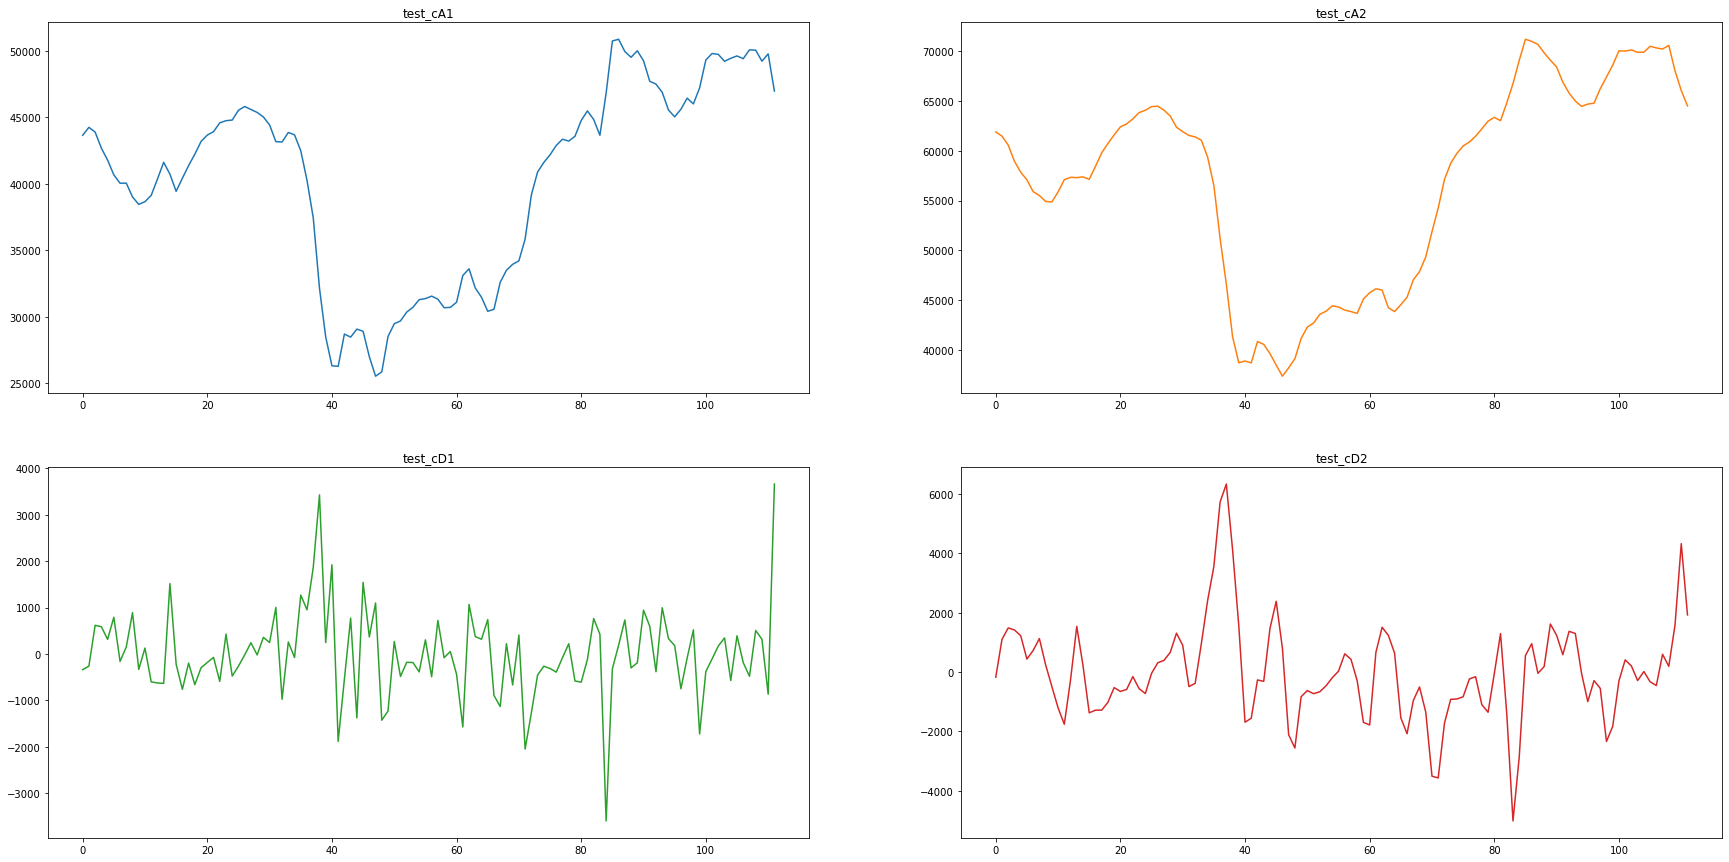

In [26]:
fig, axs = plt.subplots(2, 2, figsize= (30,15))
axs[0, 0].plot(test_cA1)
axs[0, 0].set_title('test_cA1')
axs[0, 1].plot(test_cA2, 'tab:orange')
axs[0, 1].set_title('test_cA2')
axs[1, 0].plot(test_cD1 , 'tab:green')
axs[1, 0].set_title('test_cD1')
axs[1, 1].plot(test_cD2, 'tab:red')
axs[1, 1].set_title('test_cD2')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')
#
## Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

In [27]:
test_data["cA1"] = test_cA1
test_data["cA2"] = test_cA2
test_data["cD1"] = test_cD1
test_data["cD2"] = test_cA2
test_data.head()

,Bank_Nifty,India_Vix,AD_Ratio,Labels,cA1,cA2,cD1,cD2
463,30628.35,13.90,0.714286,31105.20,43652.211832,61905.400,-337.183869,61905.400
464,31105.20,14.61,3.000000,31475.80,44251.449473,61476.400,-262.053773,61476.400
465,31475.80,14.95,2.000000,30601.45,43895.244432,60586.450,618.258814,60586.450
466,30601.45,13.07,0.142857,29770.35,42689.309172,58951.025,587.676446,58951.025
467,29770.35,12.00,0.090909,29325.30,41786.934854,57866.250,314.697873,57866.250


In [28]:
test_data.drop("Labels", axis =1)

,Bank_Nifty,India_Vix,AD_Ratio,cA1,cA2,cD1,cD2
463,30628.350000,13.90,0.714286,43652.211832,61905.400000,-337.183869,61905.400000
464,31105.200000,14.61,3.000000,44251.449473,61476.400000,-262.053773,61476.400000
465,31475.800000,14.95,2.000000,43895.244432,60586.450000,618.258814,60586.450000
466,30601.450000,13.07,0.142857,42689.309172,58951.025000,587.676446,58951.025000
467,29770.350000,12.00,0.090909,41786.934854,57866.250000,314.697873,57866.250000
...,...,...,...,...,...,...,...
570,35071.950000,12.09,0.411765,50079.953894,70221.250781,-480.726545,70221.250781
571,35751.800000,12.94,1.000000,50053.402034,70589.900781,507.278405,70589.900781
572,35034.400000,11.71,0.263158,49227.891328,68028.175781,318.232302,68028.175781
573,34584.351562,11.76,1.000000,49775.793017,66063.575781,-866.133991,66063.575781


In [29]:
test_labels = Price_Scaler.transform(np.array(test_data["Labels"]).reshape(-1,1))
test_data = Scaler.transform(test_data.drop("Labels", axis =1))

X_test = []
Y_test = []

for i in range(prediction_days+1, len(test_data) ):
    X_test.append(test_data[i - prediction_days: i, :])
    Y_test.append(test_labels[i])

X_test , Y_test = np.array(X_test), np.array(Y_test)
    

In [30]:
test_predicted_prices = model.predict(X_test)
test_predicted_prices = Price_Scaler.inverse_transform(test_predicted_prices)

In [31]:
test_actual_prices = test_actual_prices[prediction_days+1:]

In [32]:
len(test_actual_prices)

101

In [33]:
len(test_predicted_prices)

101

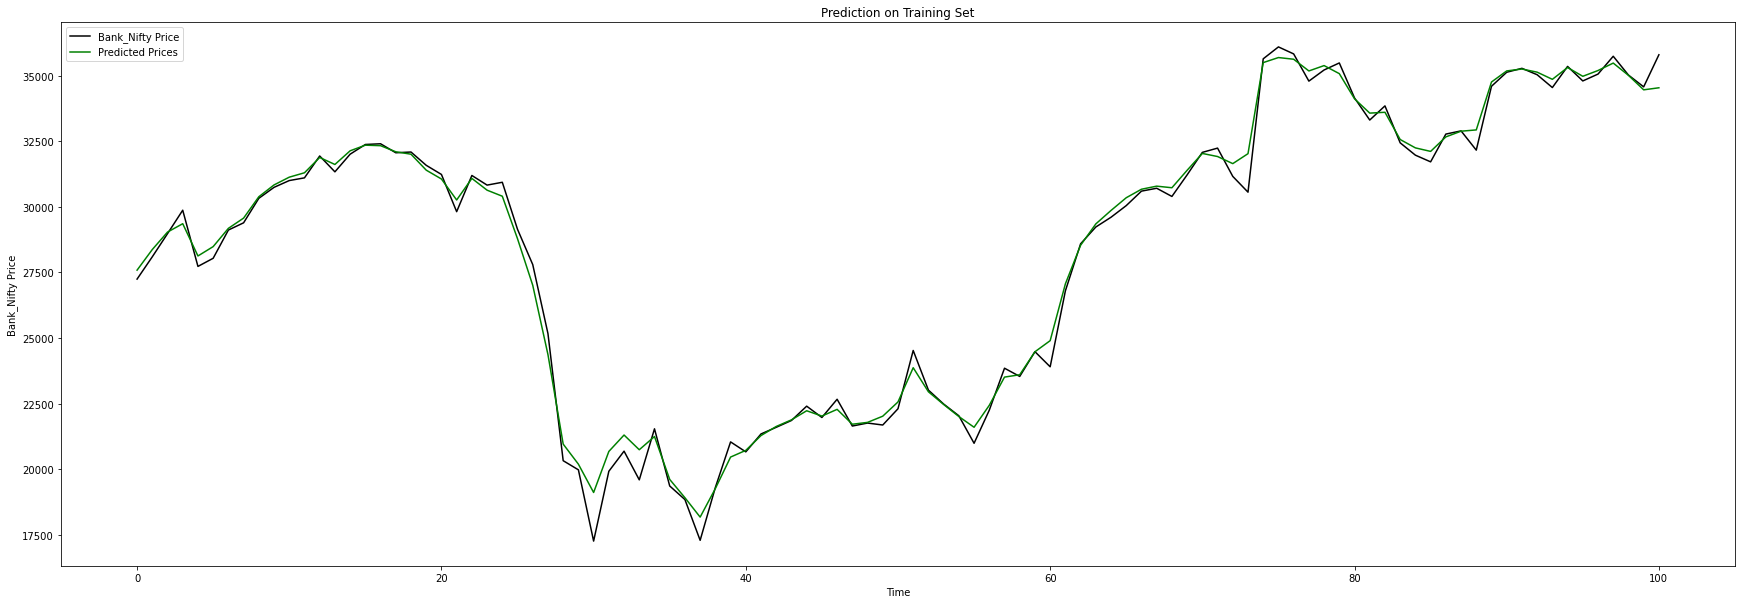

In [34]:
plt.figure(figsize = (30,10))
plt.plot(test_actual_prices, color = "black", label = "Bank_Nifty Price")
plt.plot(test_predicted_prices, color = "green", label = "Predicted Prices")
plt.title("Prediction on Training Set")
plt.xlabel("Time")
plt.ylabel("Bank_Nifty Price")
plt.legend()
plt.show()

In [35]:
corr, _ = pearsonr(test_actual_prices.flatten(), test_predicted_prices.flatten())
print("Pearson Corelation Coefficient =", corr)

Pearson Corelation Coefficient = 0.9970573323681363


In [36]:
corr, _ = spearmanr(test_actual_prices, test_predicted_prices)
print("Spearmanr Corelation Coefficient =", corr)

Spearmanr Corelation Coefficient = 0.9936983110075712


In [37]:
np.sqrt(mean_squared_error(test_actual_prices, test_predicted_prices))

435.0708928326792

In [38]:
mean_absolute_percentage_error(test_actual_prices, test_predicted_prices)

0.011373266589999891

In [39]:
%%time

rolling_model = Sequential()
rolling_model.add(LSTM(units = 60, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
rolling_model.add(Dropout(0.2))
rolling_model.add(Dense(1, activation = "relu"))
rolling_model.compile(optimizer = "Adam", loss = "mean_squared_error")
rolling_model.fit(X_train, Y_train, epochs = 100, batch_size = 16 , verbose = 0, shuffle = False)
prediction_rolling = pd.Series()

for end in range(Y_test.shape[0]):
    
    pred = rolling_model.predict((X_test[end,:,:]).reshape(1,prediction_days,-1))
    rolling_model.fit((X_test[end,:,:]).reshape(1,prediction_days,-1), Y_test[end,:].reshape(1,-1), verbose = 0, shuffle = False, epochs = 200, batch_size = 16)
    pred = Price_Scaler.inverse_transform(pred)
    prediction_rolling.loc[end] = pred[0][0]

Wall time: 1min 55s


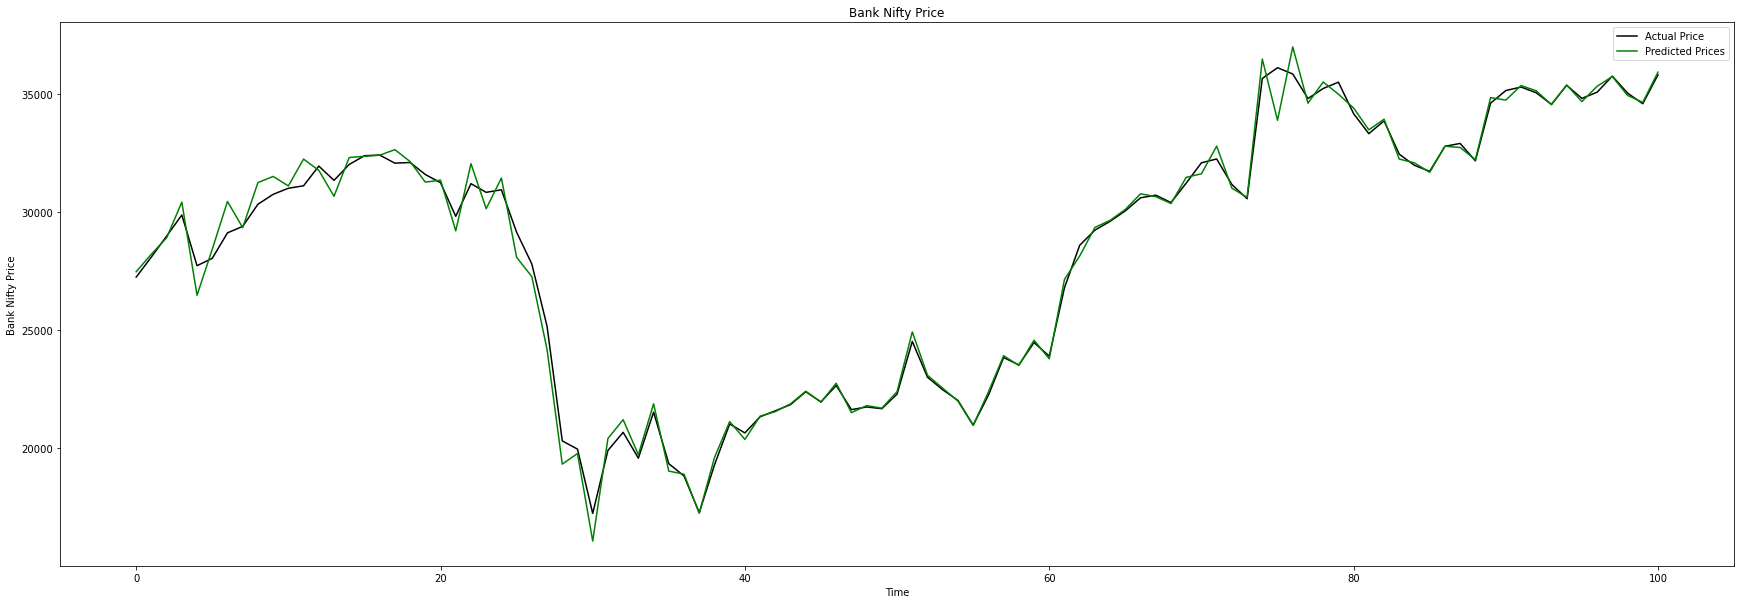

In [40]:
plt.figure(figsize = (30,10))
plt.plot(test_actual_prices, color = "black", label = "Actual Price")
plt.plot(prediction_rolling, color = "green", label = "Predicted Prices")
plt.title("Bank Nifty Price")
plt.xlabel("Time")
plt.ylabel("Bank Nifty Price")
plt.legend()
#plt.savefig('Test- Bank Nifty Wavelet LSTM.png')
plt.show()

In [41]:
Final_Results = pd.DataFrame([])
Final_Results["Actual_Prices"] = test_actual_prices
Final_Results["Predicted_Prices"] = test_predicted_prices
Final_Results["Rolling_Prices"] = prediction_rolling

In [42]:
Final_Results["PCT_CHANGE_Actual"] = Final_Results["Actual_Prices"].pct_change()
Final_Results["PCT_CHANGE_Predicted"] = Final_Results["Predicted_Prices"].pct_change()
Final_Results["PCT_CHANGE_Rolling_Predicted"] = Final_Results["Rolling_Prices"].pct_change()

In [43]:
#Binary Classification
actual_labels = np.array([])
predicted_labels = np.array([])
rolling_predicted_labels = np.array([])

for i in range(1,Final_Results.shape[0]):
    if(Final_Results["PCT_CHANGE_Actual"][i] >= 0):
        actual_labels = np.append(actual_labels,1) 
    else:
        actual_labels = np.append(actual_labels,0)

for i in range(1,Final_Results.shape[0]):
    if(Final_Results["PCT_CHANGE_Predicted"][i] >= 0):
        predicted_labels = np.append(predicted_labels,1) 
    else:
        predicted_labels = np.append(predicted_labels,0)

for i in range(1,Final_Results.shape[0]):
    if(Final_Results["PCT_CHANGE_Rolling_Predicted"][i] >= 0):
        rolling_predicted_labels = np.append(rolling_predicted_labels,1) 
    else:
        rolling_predicted_labels = np.append(rolling_predicted_labels,0)

Without Rolling Model

In [44]:
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87        43
         1.0       0.90      0.91      0.90        57

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



With Rolling Model

In [45]:
print(classification_report(actual_labels, rolling_predicted_labels))

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86        43
         1.0       0.92      0.84      0.88        57

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



In [46]:
actual_labels = np.array([])
predicted_labels = np.array([])
rolling_predicted_labels = np.array([])

for i in range(1,Final_Results.shape[0]):
    if(Final_Results["PCT_CHANGE_Actual"][i] >= 0.015):
        actual_labels = np.append(actual_labels,2) 
    if(Final_Results["PCT_CHANGE_Actual"][i] > -0.015 and Final_Results["PCT_CHANGE_Actual"][i] < 0.015):
        actual_labels = np.append(actual_labels,1)
    if(Final_Results["PCT_CHANGE_Actual"][i] <= -0.015):
        actual_labels = np.append(actual_labels,0)

for i in range(1,Final_Results.shape[0]):
    if(Final_Results["PCT_CHANGE_Predicted"][i] >= 0.015):
        predicted_labels = np.append(predicted_labels,2) 
    if(Final_Results["PCT_CHANGE_Predicted"][i] > -0.015 and Final_Results["PCT_CHANGE_Predicted"][i] < 0.015):
        predicted_labels = np.append(predicted_labels,1)
    if(Final_Results["PCT_CHANGE_Predicted"][i] <= -0.015):
        predicted_labels = np.append(predicted_labels,0)
        
for i in range(1,Final_Results.shape[0]):
    if(Final_Results["PCT_CHANGE_Rolling_Predicted"][i] >= 0.015):
        rolling_predicted_labels = np.append(rolling_predicted_labels,2) 
    if(Final_Results["PCT_CHANGE_Rolling_Predicted"][i] > -0.015 and Final_Results["PCT_CHANGE_Rolling_Predicted"][i] < 0.015):
        rolling_predicted_labels = np.append(rolling_predicted_labels,1)
    if(Final_Results["PCT_CHANGE_Rolling_Predicted"][i] <= -0.015):
        rolling_predicted_labels = np.append(rolling_predicted_labels,0)       

Without Rolling

In [47]:
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.95      0.68      0.79        31
         1.0       0.64      0.88      0.74        34
         2.0       0.87      0.77      0.82        35

    accuracy                           0.78       100
   macro avg       0.82      0.78      0.78       100
weighted avg       0.82      0.78      0.78       100



With Rolling

In [48]:
print(classification_report(actual_labels, rolling_predicted_labels))

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        31
         1.0       0.72      0.53      0.61        34
         2.0       0.73      0.86      0.79        35

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.75       100
weighted avg       0.76      0.76      0.75       100



In [49]:
## serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
## serialize weights to HDF5
#model.save_weights("WAVELET_DNN_BANK_NIFTY.h5")

In [50]:
#rolling_model_json = rolling_model.to_json()
#with open("rolling_model.json", "w") as json_file:
#    json_file.write(rolling_model_json)
#rolling_model.save_weights("Rolling_WAVELET_DNN_BANK_NIFTY.h5")

In [ ]:
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
# 
## evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))